![image](https://raw.githubusercontent.com/IBM/watsonx-ai-samples/master/cloud/notebooks/headers/watsonx-Prompt_Lab-Notebook.png)

# Use Python script to recognize hand-written digits with `ibm-watsonx-ai`

#### Disclaimers

- Use only Projects and Spaces that are available in watsonx context.

## Notebook content

Create and deploy a script that receives HTML canvas image data from a web app and then processes and sends that data to a model trained to recognize handwritten digits.  
See: <a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/fl-tf2-tutorial.html?context=wx&audience=wdp" target="_blank">MNIST function deployment tutorial</a>  

Some familiarity with Python is helpful. This notebook uses Python 3.11.

## Learning goals
The learning goals of this notebook are:

- Create and save a Python script.
- Deploy the script using the client library.
- Create and run a job which utilizes the created deployment.

## Contents
This notebook contains the following parts:

1. [Setup](#section1)
2. [Get an ID for a model deployment](#section2)
3. [Get sample canvas data](#section3)
4. [Python Script Deployment](#section4)
5. [Create and Run job](#section5)
6. [Clean up](#section6)
7. [Summary](#section7)

<a id="section1"></a>
## Set up the environment

Before you use the sample code in this notebook, you must perform the following setup tasks:

-  Create a <a href="https://cloud.ibm.com/catalog/services/watsonxai-runtime" target="_blank" rel="noopener no referrer">watsonx.ai Runtime Service</a> instance (a free plan is offered and information about how to create the instance can be found <a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/getting-started/wml-plans.html?context=wx&audience=wdp" target="_blank" rel="noopener no referrer">here</a>).

### Install dependencies
**Note:** `ibm-watsonx-ai` documentation can be found <a href="https://ibm.github.io/watsonx-ai-python-sdk/index.html" target="_blank" rel="noopener no referrer">here</a>.

In [1]:
%pip install -U ibm-watsonx-ai | tail -n 1
%pip install -U matplotlib | tail -n 1
%pip install -U wget | tail -n 1

### Connection to watsonx.ai Runtime

Authenticate the watsonx.ai Runtime service on IBM Cloud. You need to provide platform `api_key` and instance `location`.

You can use [IBM Cloud CLI](https://cloud.ibm.com/docs/cli/index.html) to retrieve platform API Key and instance location.

API Key can be generated in the following way:
```
ibmcloud login
ibmcloud iam api-key-create API_KEY_NAME
```

In result, get the value of `api_key` from the output.


Location of your watsonx.ai Runtime instance can be retrieved in the following way:
```
ibmcloud login --apikey API_KEY -a https://cloud.ibm.com
ibmcloud resource service-instance INSTANCE_NAME
```

In result, get the value of `location` from the output.

**Tip**: Your `Cloud API key` can be generated by going to the [**Users** section of the Cloud console](https://cloud.ibm.com/iam#/users). From that page, click your name, scroll down to the **API Keys** section, and click **Create an IBM Cloud API key**. Give your key a name and click **Create**, then copy the created key and paste it below. You can also get a service specific url by going to the [**Endpoint URLs** section of the watsonx.ai Runtime docs](https://cloud.ibm.com/apidocs/machine-learning).  You can check your instance location in your  <a href="https://cloud.ibm.com/catalog/services/watsonxai-runtime" target="_blank" rel="noopener no referrer">watsonx.ai Runtime Service</a> instance details.

You can also get service specific apikey by going to the [**Service IDs** section of the Cloud Console](https://cloud.ibm.com/iam/serviceids).  From that page, click **Create**, then copy the created key and paste it below.

**Action**: Enter your `api_key` and `location` in the following cell.

In [2]:
import getpass

from ibm_watsonx_ai import Credentials

api_key = getpass.getpass("Please enter your watsonx.ai api key (hit enter): ")

credentials = Credentials(
    url="https://us-south.ml.cloud.ibm.com",
    api_key=api_key,
)

Please enter your watsonx.ai api key (hit enter):  ········


### Working with spaces

First of all, you need to create a space that will be used for your work. If you do not have space already created, you can use [Deployment Spaces Dashboard](https://dataplatform.cloud.ibm.com/ml-runtime/spaces?context=cpdaas) to create one.

- Click New Deployment Space
- Create an empty space
- Select Cloud Object Storage
- Select watsonx.ai Runtime instance and press Create
- Copy `space_id` and paste it below

**Tip**: You can also use SDK to prepare the space for your work. More information can be found [here](https://github.com/IBM/watson-machine-learning-samples/blob/master/cloud/notebooks/python_sdk/instance-management/Space%20management.ipynb).

**Action**: Assign space ID below

In [3]:
import os

try:
    space_id = os.environ["SPACE_ID"]
except KeyError:
    space_id = input("Please enter your space_id (hit enter): ")

Please enter your space_id (hit enter):  0277b6be-7b18-4f65-bc88-168f8d05691a


#### Create `APIClient` instance

In [4]:
from ibm_watsonx_ai import APIClient

client = APIClient(credentials=credentials, space_id=space_id)

## <a id="section2"></a> Get an ID for a model deployment

The deployed function created in this notebook is designed to send payload data to a TensorFlow model created in the <a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/fl-tf2-tutorial.html?context=wx&audience=wdp" target="_blank" rel="noopener noreferrer">MNIST tutorials</a>.

### Option 1: Use your own, existing model deployment

If you already deployed a model while working through one of the following MNIST tutorials, you can use that model deployment:
- <a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/fl-tf2-tutorial.html?context=wx&audience=wdp" target="_blank" rel="noopener noreferrer">Experiment builder MNIST tutorial</a>

Paste the model deployment ID in the following cell.

See: <a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/wmls/wmls-deploy-overview.html?context=wx&audience=wdp" target="_blank" rel="noopener noreferrer">Looking up an online deployment ID</a>


In [5]:
model_deployment_id = input("Please enter your model deployment ID (hit enter to skip)")

### Option 2: Download, store, and deploy a sample model
You can deployed a sample model and get its deployment ID by running the code in the following four cells.

In [6]:
import os

import wget

# Download a sample model to the notebook working directory

sample_saved_model_filename = "mnist-tf-hpo-saved-model.tar.gz"
url = (
    "https://github.com/IBM/watsonx-ai-samples/raw/master/cloud/models/tensorflow/mnist/"
    + sample_saved_model_filename
)
if not os.path.isfile(sample_saved_model_filename):
    wget.download(url)

In [7]:
# Look up software specification for the MNIST model

software_spec_id = client.software_specifications.get_id_by_name("runtime-24.1-py3.11")

In [8]:
# Store the sample model in your watsonx.ai Runtime repository

metadata = {
    client.repository.ModelMetaNames.NAME: "Saved MNIST model",
    client.repository.ModelMetaNames.TYPE: "tensorflow_2.14",
    client.repository.ModelMetaNames.SOFTWARE_SPEC_ID: software_spec_id,
}
model_details = client.repository.store_model(
    model=sample_saved_model_filename, meta_props=metadata
)

In [9]:
# Get published model ID

published_model_id = client.repository.get_model_id(model_details)

In [10]:
# Deploy the stored model
metadata = {
    client.deployments.ConfigurationMetaNames.NAME: "MNIST saved model deployment",
    client.deployments.ConfigurationMetaNames.ONLINE: {},
}

model_deployment_details = client.deployments.create(
    published_model_id, meta_props=metadata
)



######################################################################################

Synchronous deployment creation for id: '948505d6-5218-469a-8012-a5ac90253868' started

######################################################################################


initializing
Note: online_url and serving_urls are deprecated and will be removed in a future release. Use inference instead.
......
ready


-----------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_id='0d94fc88-6f68-4de1-aa9d-c5a4f674a77c'
-----------------------------------------------------------------------------------------------




In [11]:
# Get the ID of the model deployment just created

model_deployment_id = client.deployments.get_id(model_deployment_details)
print(model_deployment_id)

0d94fc88-6f68-4de1-aa9d-c5a4f674a77c


## <a id="section3"></a> Get sample canvas data

The deployed function created in this notebook is designed to accept RGBA image data from an HTML canvas object.

Run the following cells to download and view sample canvas data for testing the deployed function.

### Download sample data file

In [12]:
# Download the file containing the sample data

sample_canvas_data_filename = "mnist-html-canvas-image-data.json"
url = (
    "https://github.com/IBM/watsonx-ai-samples/raw/master/cloud/data/mnist/"
    + sample_canvas_data_filename
)
if not os.path.isfile(sample_canvas_data_filename):
    wget.download(url)

In [13]:
import json

# Load the sample data from the file into a variable

with open(sample_canvas_data_filename) as data_file:
    sample_canvas_data = json.load(data_file)

### View sample data

In [14]:
# View the raw contents of the sample data

print(f"Height (n): {str(sample_canvas_data['height'])} pixels\n")
print(
    f"Num image data entries: {str(len(sample_canvas_data['data']))} - (n * n * 4) elements - RGBA values\n"
)
print(
    f"{json.dumps(sample_canvas_data, indent=3)[:75]}"
    f"...\n"
    f"{json.dumps(sample_canvas_data, indent=3)[-50:]}"
)


Height (n): 187 pixels

Num image data entries: 139876 - (n * n * 4) elements - RGBA values

{
   "data": [
      0,
      0,
      0,
      0,
      0,
      0,
      ...
      0,
      0,
      0
   ],
   "height": 187
}


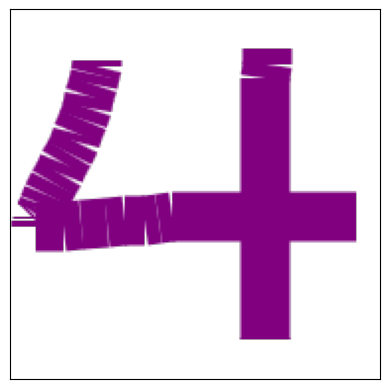

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# See what hand-drawn digit the sample data represents

rgba_arr = np.asarray(sample_canvas_data["data"]).astype("uint8")
n = sample_canvas_data["height"]
plt.figure()
plt.imshow(rgba_arr.reshape(n, n, 4))
plt.xticks([])
plt.yticks([])
plt.show()

<a id='section4'></a>
## Python Script Deployment

### Save Python Script

This file will be saved locally so you can deploy and run it later.

In [16]:
script = """
import os
import json
import traceback
import pandas as pd
import numpy as np
from PIL import Image
from ibm_watsonx_ai import APIClient, Credentials


JOBS_PAYLOAD_FILE = os.getenv("JOBS_PAYLOAD_FILE", "")
BATCH_INPUT_DIR = os.getenv("BATCH_INPUT_DIR", "")
BATCH_OUTPUT_DIR = os.getenv("BATCH_OUTPUT_DIR", "")
API_KEY = os.getenv("API_KEY", "")
LOCATION = os.getenv("LOCATION", "")
SPACE_ID = os.getenv("SPACE_ID", "")
MODEL_DEPLOYMENT_ID = os.getenv("MODEL_DEPLOYMENT_ID", "")

if not any(
    (
        JOBS_PAYLOAD_FILE,
        BATCH_INPUT_DIR,
        BATCH_OUTPUT_DIR,
        API_KEY,
        LOCATION,
        SPACE_ID,
        MODEL_DEPLOYMENT_ID
    )
):
    exit(1)


def getRGBAArr(canvas_data):
    dimension = canvas_data[1]
    rgba_data = canvas_data[0]
    rgba_arr = np.asarray(rgba_data).astype("uint8")

    return rgba_arr.reshape(dimension, dimension, 4)


def getNormAlphaList(img):
    alpha_arr = np.array(img.split()[-1])
    norm_alpha_arr = alpha_arr / 255
    norm_alpha_list = norm_alpha_arr.reshape(1, 784).tolist()
    return norm_alpha_list


def main():
    try:
        with open(JOBS_PAYLOAD_FILE, 'r') as fp:
            data = json.load(fp)
            function_payload = data['scoring']

        canvas_data = function_payload["input_data"][0]["values"]  # Read the payload received by the function
        rgba_arr = getRGBAArr(
            canvas_data
        )  # Create an array object with the required shape
        img = Image.fromarray(
            rgba_arr, "RGBA"
        )  # Create an image object that can be resized
        sm_img = img.resize(
            (28, 28), Image.LANCZOS
        )  # Resize the image to 28 x 28 pixels
        alpha_list = getNormAlphaList(
            sm_img
        )  # Create a 1 x 784 array of values between 0 and 1
        model_payload = {
            "input_data": [{"values": alpha_list}]
        }  # Create a payload to be sent to the model

        credentials = Credentials(
            api_key=API_KEY,
            url='https://' + LOCATION + '.ml.cloud.ibm.com'
        )
        client = APIClient(credentials)
        client.set.default_space(SPACE_ID)
        model_result = client.deployments.score(
            MODEL_DEPLOYMENT_ID, model_payload
        )

        with open(os.path.join(BATCH_OUTPUT_DIR, 'output.json'), 'w') as fp:
            json.dump(model_result, fp)

        return model_result
        
    except Exception as e:
        tb = traceback.format_exc()
        with open(os.path.join(BATCH_OUTPUT_DIR, 'output.json'), 'w') as fp:
            json.dump({"predictions": [{"values": [tb]}]}, fp)
            


if __name__ == "__main__":
    main()
"""

with open("/tmp/script.py", "w") as fp:
    fp.writelines(script)

The file should be successfully created. 
To check its content, you can use the command below.

In [17]:
from IPython.display import Markdown, display

with open("/tmp/script.py", "r") as f:
    code_content = f.read()

display(Markdown(f"```python\n{code_content}\n```"))

```python

import os
import json
import traceback
import pandas as pd
import numpy as np
from PIL import Image
from ibm_watsonx_ai import APIClient, Credentials


JOBS_PAYLOAD_FILE = os.getenv("JOBS_PAYLOAD_FILE", "")
BATCH_INPUT_DIR = os.getenv("BATCH_INPUT_DIR", "")
BATCH_OUTPUT_DIR = os.getenv("BATCH_OUTPUT_DIR", "")
API_KEY = os.getenv("API_KEY", "")
LOCATION = os.getenv("LOCATION", "")
SPACE_ID = os.getenv("SPACE_ID", "")
MODEL_DEPLOYMENT_ID = os.getenv("MODEL_DEPLOYMENT_ID", "")

if not any(
    (
        JOBS_PAYLOAD_FILE,
        BATCH_INPUT_DIR,
        BATCH_OUTPUT_DIR,
        API_KEY,
        LOCATION,
        SPACE_ID,
        MODEL_DEPLOYMENT_ID
    )
):
    exit(1)


def getRGBAArr(canvas_data):
    dimension = canvas_data[1]
    rgba_data = canvas_data[0]
    rgba_arr = np.asarray(rgba_data).astype("uint8")

    return rgba_arr.reshape(dimension, dimension, 4)


def getNormAlphaList(img):
    alpha_arr = np.array(img.split()[-1])
    norm_alpha_arr = alpha_arr / 255
    norm_alpha_list = norm_alpha_arr.reshape(1, 784).tolist()
    return norm_alpha_list


def main():
    try:
        with open(JOBS_PAYLOAD_FILE, 'r') as fp:
            data = json.load(fp)
            function_payload = data['scoring']

        canvas_data = function_payload["input_data"][0]["values"]  # Read the payload received by the function
        rgba_arr = getRGBAArr(
            canvas_data
        )  # Create an array object with the required shape
        img = Image.fromarray(
            rgba_arr, "RGBA"
        )  # Create an image object that can be resized
        sm_img = img.resize(
            (28, 28), Image.LANCZOS
        )  # Resize the image to 28 x 28 pixels
        alpha_list = getNormAlphaList(
            sm_img
        )  # Create a 1 x 784 array of values between 0 and 1
        model_payload = {
            "input_data": [{"values": alpha_list}]
        }  # Create a payload to be sent to the model

        credentials = Credentials(
            api_key=API_KEY,
            url='https://' + LOCATION + '.ml.cloud.ibm.com'
        )
        client = APIClient(credentials)
        client.set.default_space(SPACE_ID)
        model_result = client.deployments.score(
            MODEL_DEPLOYMENT_ID, model_payload
        )

        with open(os.path.join(BATCH_OUTPUT_DIR, 'output.json'), 'w') as fp:
            json.dump(model_result, fp)

        return model_result

    except Exception as e:
        tb = traceback.format_exc()
        with open(os.path.join(BATCH_OUTPUT_DIR, 'output.json'), 'w') as fp:
            json.dump({"predictions": [{"values": [tb]}]}, fp)



if __name__ == "__main__":
    main()

```

### Deployment of Python Script

You can store and deploy a Python script and get its details by running the code in following cells. 

In [18]:
base_sw_spec_id = client.software_specifications.get_uid_by_name("runtime-24.1-py3.11")
print(base_sw_spec_id)

45f12dfe-aa78-5b8d-9f38-0ee223c47309


In [19]:
meta_props = {
    client.script.ConfigurationMetaNames.NAME: "Python script",
    client.script.ConfigurationMetaNames.SOFTWARE_SPEC_UID: base_sw_spec_id,
}

In [20]:
script_path = "/tmp/script.py"
script_details = client.script.store(meta_props, file_path=script_path)
script_id = client.script.get_id(script_details)
print("Created script ", script_id)

Creating Script asset...
SUCCESS
Created script  046a49fc-1c91-43d2-a07d-1f15fe2b8047


In [21]:
deployment_meta_props = {
    client.deployments.ConfigurationMetaNames.NAME: "pyscript_deployment",
    client.deployments.ConfigurationMetaNames.BATCH: {},
    client.deployments.ConfigurationMetaNames.HARDWARE_SPEC: {"name": "S"},
}

deployment_details = client.deployments.create(script_id, deployment_meta_props)
deployment_id = client.deployments.get_id(deployment_details)



######################################################################################

Synchronous deployment creation for id: '046a49fc-1c91-43d2-a07d-1f15fe2b8047' started

######################################################################################


ready.


-----------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_id='3c817e8b-4d97-4543-b3e9-9a2500bb9243'
-----------------------------------------------------------------------------------------------




<a id='section5'></a>
## Create and Run job

Run the following cells to create and run a job with the deployed script.

In [22]:
import time


def poll_async_job(wml_client, job_uid):
    while True:
        job_status = wml_client.deployments.get_job_status(job_uid)
        print(job_status)
        state = job_status["state"]
        if state == "completed" or "fail" in state:
            return wml_client.deployments.get_job_details(job_uid)
        time.sleep(5)

In [23]:
job_payload_ref = {
    client.deployments.ScoringMetaNames.INPUT_DATA: [
        {
            "fields": ["data", "height"],
            "values": [sample_canvas_data["data"], sample_canvas_data["height"]],
        }
    ],
    client.deployments.ScoringMetaNames.OUTPUT_DATA_REFERENCE: {
        "type": "data_asset",
        "location": {"name": "deploy_test_script-out"},
    },
    client.deployments.ScoringMetaNames.ENVIRONMENT_VARIABLES: {
        "API_KEY": api_key,
        "LOCATION": "us-south",
        "SPACE_ID": space_id,
        "MODEL_DEPLOYMENT_ID": model_deployment_id,
    },
}

job = client.deployments.create_job(deployment_id, meta_props=job_payload_ref)
job_id = client.deployments.get_job_id(job)

In [24]:
job_details = poll_async_job(client, job_id)

{'completed_at': '', 'running_at': '', 'state': 'queued'}
{'completed_at': '', 'running_at': '', 'state': 'queued'}
{'completed_at': '', 'running_at': '', 'state': 'queued'}
{'completed_at': '', 'running_at': '', 'state': 'queued'}
{'completed_at': '', 'running_at': '2025-09-17T08:28:39.654Z', 'state': 'running'}
{'completed_at': '', 'running_at': '2025-09-17T08:28:39.654Z', 'state': 'running'}
{'completed_at': '', 'running_at': '2025-09-17T08:28:39.654Z', 'state': 'running'}
{'completed_at': '2025-09-17T08:28:58.867355Z', 'running_at': '2025-09-17T08:28:39.574719Z', 'state': 'completed'}


In [25]:
client.data_assets.list().iloc[-1]

NAME                        deploy_test_script-out
ASSET_TYPE                              data_asset
SIZE                                            51
ASSET_ID      b0ad383f-82bb-4307-8512-c737789ca51f
Name: 7, dtype: object

To download the asset run the code below. It will be downloaded as a zip archive.

In [26]:
scoring_params = client.deployments.get_job_details(job_id)

from ibm_watsonx_ai.helpers import DataConnection

output_data_connection = DataConnection.from_dict(
    scoring_params["entity"]["scoring"]["output_data_reference"]
)
output_data_connection.set_client(client)

output_data_connection.download("/tmp/script_result.json")

  Using cached pyarrow-21.0.0-cp311-cp311-macosx_12_0_arm64.whl.metadata (3.3 kB)
Using cached pyarrow-21.0.0-cp311-cp311-macosx_12_0_arm64.whl (31.2 MB)


In [27]:
with open("/tmp/script_result.json") as fp:
    result = json.load(fp)

print(result)

{'predictions': [{'id': 'classes', 'values': [4]}]}


<a id='section6'></a>
## Cleanup 

If you want to clean up all created assets:
- experiments
- trainings
- pipelines
- model definitions
- models
- functions
- deployments

please follow up this sample [notebook](https://github.com/IBM/watsonx-ai-samples/blob/master/cpd5.2/notebooks/python_sdk/instance-management/Machine%20Learning%20artifacts%20management.ipynb).

<a id="section7"></a>
## Summary and next steps

You successfully completed this notebook!
 
You created a Python script that receives HTML canvas image data and then processes and sends that data to a model trained to recognize handwritten digits.
 
Check out our _<a href="https://ibm.github.io/watsonx-ai-python-sdk/samples.html" target="_blank" rel="noopener no referrer">Online Documentation</a>_ for more samples, tutorials, documentation, how-tos, and blog posts. 

### Author

**Jakub Owczarek**, Software Engineer at watsonx.ai

Copyright © 2025 IBM. This notebook and its source code are released under the terms of the MIT License.